In [1]:
import numpy as np 
import pandas as pd
import os,cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras
from keras_visualizer import visualizer
from keras import callbacks
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense , Activation , Dropout ,Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.metrics import categorical_accuracy
from keras.models import model_from_json
from keras.callbacks import ModelCheckpoint
from keras.optimizers import *
from keras.layers.normalization import BatchNormalization
import os

AttributeError: module 'keras.utils.generic_utils' has no attribute 'populate_dict_with_module_objects'

# load data and add labels 

In [2]:
names = ['anger','contempt','disgust','fear','happy','sadness','surprise', 'neutral']

num_classes = len(names)

labels = []

def getLabel(id):
    return ['anger','contempt','disgust','fear','happy','sadness','surprise', 'neutral'][id]

def getLabelNum(emotion):
    label_dict = dict({
        'anger'     : 0,
        'angry'     : 0,
        'contempt'  : 1,
        'disgust'   : 2,
        'fear'      : 3,
        'happy'     : 4,
        'sadness'   : 5,
        'sad'       : 5,
        'surprise'  : 6,
        'neutral'   : 7
    })
    return label_dict[emotion]

## CK+ dataset

In [3]:
data_path = 'dataset/CK+48'
data_dir_list = os.listdir(data_path)

img_data_list=[]

for dataset in data_dir_list:
    img_list=os.listdir(data_path+'/'+ dataset)
    print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
    for img in img_list:
        input_img=cv2.imread(data_path + '/'+ dataset + '/'+ img )
        input_img=cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
        input_img_resize=cv2.resize(input_img,(48,48))
        img_data_list.append(input_img_resize)
        labels.append(getLabelNum(dataset))
        
img_data = np.array(img_data_list)
img_data = img_data.astype('float32')
img_data = img_data/255
img_data.shape

Loaded the images of dataset-anger

Loaded the images of dataset-contempt

Loaded the images of dataset-disgust

Loaded the images of dataset-fear

Loaded the images of dataset-happy

Loaded the images of dataset-sadness

Loaded the images of dataset-surprise



(327, 48, 48)

## FER dataset

In [4]:
data_path = 'dataset/fer'
data_dir_list = os.listdir(data_path)

for dataset in data_dir_list:
    img_list=os.listdir(data_path+'/'+ dataset)
    print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
    for img in img_list:
        input_img=cv2.imread(data_path + '/'+ dataset + '/'+ img )
        input_img=cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
        input_img_resize=cv2.resize(input_img,(48,48))
        img_data_list.append(input_img_resize)
        labels.append(getLabelNum(dataset))
        
img_data = np.array(img_data_list)
img_data = img_data.astype('float32')
img_data = img_data/255
img_data.shape

Loaded the images of dataset-angry

Loaded the images of dataset-disgust

Loaded the images of dataset-fear

Loaded the images of dataset-happy

Loaded the images of dataset-neutral

Loaded the images of dataset-sad

Loaded the images of dataset-surprise



(36214, 48, 48)

In [5]:
num_of_samples = img_data.shape[0]
labels = np.array(labels)
num_of_samples, labels.shape

(36214, (36214,))

# dividing into training and testing

In [6]:
Y = np_utils.to_categorical(labels, num_classes)

X_train, X_test, y_train, y_test = train_test_split(img_data, Y, test_size=0.30, shuffle=True, random_state=42)
X_train = np.reshape(X_train, (X_train.shape[0], 48, 48, 1))
X_test = np.reshape(X_test, (X_test.shape[0], 48, 48, 1))

print(Y.shape)
print(X_train.shape)
print(X_test.shape)

(36214, 8)
(25349, 48, 48, 1)
(10865, 48, 48, 1)


# creating model

In [20]:
input_shape=(48,48,1)

model = Sequential()

model.add(Conv2D(6, (4, 4), input_shape = input_shape))
model.add(Activation('relu'))
model.add(Conv2D(16, (5, 5), padding = 'same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
# model.add(Dropout(0.7))
model.add(Dense(8, activation = 'softmax'))

model.summary()

visualizer(model, format='png')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 45, 45, 6)         102       
_________________________________________________________________
activation_4 (Activation)    (None, 45, 45, 6)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 45, 45, 16)        2416      
_________________________________________________________________
activation_5 (Activation)    (None, 45, 45, 16)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 16)        0         
_________________________________________________________________
activation_6 (Activation)    (None, 22, 22, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 20, 20, 64)       

# training the model

In [21]:
filename='model_train_new.csv'
filepath = os.path.join("./emotion_detector_models/model_v6_{epoch}.hdf5")

checkpoint = keras.callbacks.ModelCheckpoint(filepath,
                                             monitor='val_acc',
                                             verbose=1,
                                             save_best_only=True,
                                             mode='max')
# callbacks = [checkpoint]


csv_log=callbacks.CSVLogger(filename, separator=',', append=False)
# checkpoint = callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [csv_log,checkpoint]
callbacks_list = [csv_log]

In [22]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', 'MeanSquaredError'])

In [24]:
model_info = model.fit(X_train, y_train, batch_size=1, epochs=5, validation_data=(X_test, y_test), callbacks=callbacks_list)

Epoch 1/5
25349/25349 [==============================] - 177s 7ms/step - loss: 1.2246 - accuracy: 0.5351 - mean_squared_error: 0.0735 - val_loss: 1.3735 - val_accuracy: 0.4836 - val_mean_squared_error: 0.0802
Epoch 2/5
25349/25349 [==============================] - 204s 8ms/step - loss: 1.1504 - accuracy: 0.5676 - mean_squared_error: 0.0695 - val_loss: 1.4350 - val_accuracy: 0.4852 - val_mean_squared_error: 0.0816
Epoch 3/5
25349/25349 [==============================] - 196s 8ms/step - loss: 1.0752 - accuracy: 0.5991 - mean_squared_error: 0.0655 - val_loss: 1.4290 - val_accuracy: 0.4913 - val_mean_squared_error: 0.0815
Epoch 4/5
25349/25349 [==============================] - 191s 8ms/step - loss: 1.0032 - accuracy: 0.6272 - mean_squared_error: 0.0615 - val_loss: 1.4769 - val_accuracy: 0.4869 - val_mean_squared_error: 0.0824
Epoch 5/5
25349/25349 [==============================] - 192s 8ms/step - loss: 0.9445 - accuracy: 0.6493 - mean_squared_error: 0.0581 - val_loss: 1.4965 - val_accur

# predict model

In [25]:
# evaluate the model
score = model.evaluate(X_train, y_train)
print('Accuracy (train): %.2f' % (score[1]*100))

score = model.evaluate(X_test, y_test)
print('Accuracy (test): %.2f' % (score[1]*100))

793/793 [==============================] - 20s 23ms/step - loss: 0.8937 - accuracy: 0.6729 - mean_squared_error: 0.0555
Accuracy (train): 67.29
340/340 [==============================] - 8s 24ms/step - loss: 1.4965 - accuracy: 0.4737 - mean_squared_error: 0.0842
Accuracy (test): 47.37


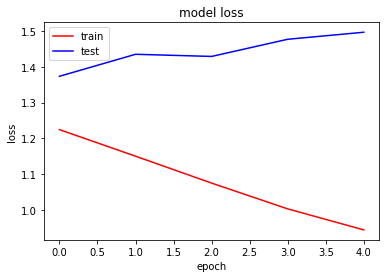

In [26]:
plt.plot(model_info.history['loss'], 'r', label='train')
plt.plot(model_info.history['val_loss'], 'b', label='test')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

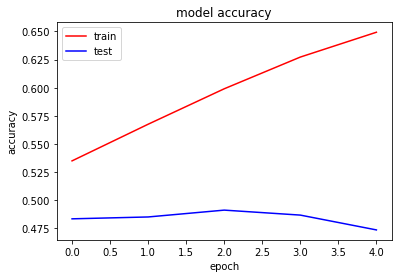

In [27]:
plt.plot(model_info.history['accuracy'], 'r', label='train')
plt.plot(model_info.history['val_accuracy'], 'b', label='test')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

(1, 48, 48, 1)
[[2.2509131e-03 0.0000000e+00 1.1144415e-10 7.5816855e-02 1.9462772e-01
  6.9677693e-01 2.7091393e-05 3.0500516e-02]]
[5]
[[0. 0. 0. 1. 0. 0. 0. 0.]]


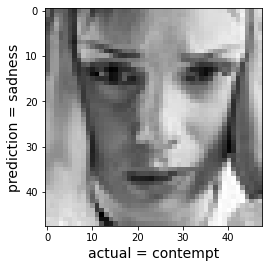

In [14]:
test_image = X_test[0:1]
print (test_image.shape)

print(model.predict(test_image))
print(np.argmax(model.predict(test_image), axis=-1))
print(y_test[0:1])

plt.imshow(test_image[0],cmap=plt.get_cmap('gray'))
plt.ylabel('prediction = %s' % getLabel(np.argmax(model.predict(test_image), axis=-1)[0]), fontsize=14)
plt.xlabel('actual = %s' % getLabel(1 in y_test[0:1]), fontsize=14)
plt.show()

(1, 48, 48, 1)
[[0. 0. 0. 0. 0. 0. 1. 0.]]
[6]
[[0. 0. 0. 1. 0. 0. 0. 0.]]


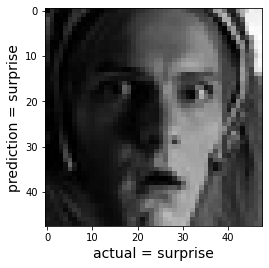

In [15]:
test_image = cv2.imread('test_images/surprise.jpg')
test_img_gray = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
test_image_resize = cv2.resize(test_img_gray,(48,48))
test_image_resize = np.reshape(test_image_resize, (1, 48, 48, 1))
print (test_image_resize.shape)

print(model.predict(test_image_resize))
print(np.argmax(model.predict(test_image_resize), axis=-1))
print(y_test[0:1])

plt.imshow(test_image_resize[0],cmap=plt.get_cmap('gray'))
plt.ylabel('prediction = %s' % getLabel(np.argmax(model.predict(test_image_resize), axis=-1)[0]), fontsize=14)
plt.xlabel('actual = %s' % 'surprise', fontsize=14)
plt.show()

(1, 48, 48, 1)
[[8.2583231e-04 0.0000000e+00 2.0647208e-12 1.7266488e-04 9.9333596e-01
  3.7138399e-03 2.3529431e-06 1.9493054e-03]]
[4]
[[0. 0. 0. 0. 0. 1. 0. 0.]]


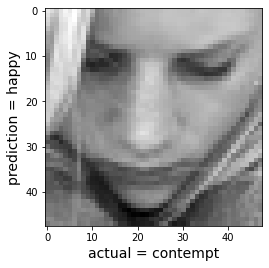

In [16]:
test_image = X_test[33:34]
print (test_image.shape)

print(model.predict(test_image))
print(np.argmax(model.predict(test_image), axis=-1))
print(y_test[33:34])

plt.imshow(test_image[0],cmap=plt.get_cmap('gray'))
plt.ylabel('prediction = %s' % getLabel(np.argmax(model.predict(test_image), axis=-1)[0]), fontsize=14)
plt.xlabel('actual = %s' % getLabel(1 in y_test[33:34]), fontsize=14)

plt.show()

In [17]:
model.save('my_model_2.hdf5')